In [0]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import geopandas as gpd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns', None)

In [0]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

In [0]:
from regressors import stats

In [0]:
Y = pd.read_csv('Y.csv',index_col=[0])

In [0]:
X = pd.read_csv('X.csv',index_col=[0])
X.head(3)

,Largest Property Use Type,Year Built,ENERGY STAR Score,bldgclass,landuse,Self-Reported Gross Floor Area (ft²),Occupancy,bldgarea,numfloors,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,assessland,assesstot,builtfar
0,Multifamily Housing,"1,959",87,D4,3.0,0.021340,1.0,0.021477,0.156863,0.000000,0.101654,0.000000,0.000000,0.0,0.0,0.0,0.002989,0.011194,0.072727
1,Worship Facility,"1,931",1,M1,8.0,0.003770,1.0,0.026300,0.029412,0.246165,0.000000,0.324291,0.000000,0.0,0.0,0.0,0.006235,0.021549,0.028458
2,Office,"1,977",50,O4,5.0,0.023691,1.0,0.023312,0.313725,0.246165,0.000000,0.318723,0.017171,0.0,0.0,0.0,0.047046,0.059030,0.290232


In [0]:
Y.columns = ['GHG Change']
Y

,GHG Change
0,
1,2
2,2
3,2
4,1
7,1
...,...
13701,2
13705,0
13707,0


### Exploration 

#### Largest Property Use Type 

In [0]:
### merge building types <30 to others

In [0]:
X.loc[X['Largest Property Use Type'].str.contains("Other"), 'Largest Property Use Type'] = "Other"

In [0]:
building_type = X['Largest Property Use Type'].value_counts().to_frame()

In [0]:
type_list = building_type[building_type['Largest Property Use Type']<30].index.to_list()

In [0]:
dct = {}
for _ in type_list:
    dct[_] = 'Other'

In [0]:
X.loc[:, 'Largest Property Use Type'] = X['Largest Property Use Type'].apply(lambda x: dct.get(x, x))

In [0]:
X['Largest Property Use Type'].value_counts()

Multifamily Housing                      8502
Office                                   1162
Other                                     325
Hotel                                     158
Residence Hall/Dormitory                   99
College/University                         93
Non-Refrigerated Warehouse                 92
Senior Care Community                      91
Retail Store                               76
Self-Storage Facility                      68
K-12 School                                64
Distribution Center                        38
Hospital (General Medical & Surgical)      34
Manufacturing/Industrial Plant             34
Parking                                    32
Name: Largest Property Use Type, dtype: int64

In [0]:
merge = X.merge(Y,left_index=True, right_index=True)

In [0]:
merge.head(3)

,Largest Property Use Type,Year Built,ENERGY STAR Score,bldgclass,landuse,Self-Reported Gross Floor Area (ft²),Occupancy,bldgarea,numfloors,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,assessland,assesstot,builtfar,GHG Change
1,Other,"1,931",1,M1,8.0,0.003770,1.0,0.026300,0.029412,0.246165,0.0,0.324291,0.000000,0.0,0.0,0.000000,0.006235,0.021549,0.028458,1
2,Office,"1,977",50,O4,5.0,0.023691,1.0,0.023312,0.313725,0.246165,0.0,0.318723,0.017171,0.0,0.0,0.000000,0.047046,0.059030,0.290232,1
3,Manufacturing/Industrial Plant,"1,994",Not Available,F2,6.0,0.040819,1.0,0.033010,0.029412,0.246165,0.0,0.136856,0.000000,0.0,0.0,0.577983,0.055598,0.029931,0.004065,2


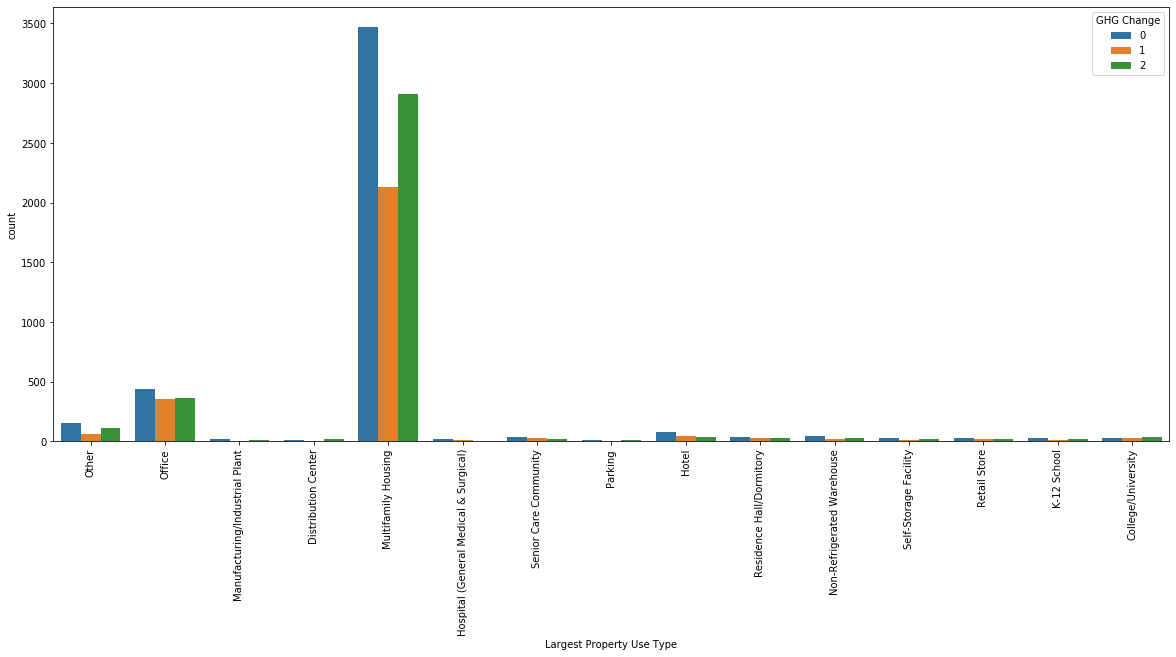

In [0]:
plt.figure(figsize=(20, 8))
sns.countplot(merge['Largest Property Use Type'], hue='GHG Change', data=merge)
plt.xticks(rotation=90)
plt.show()

<Figure size 1440x576 with 0 Axes>

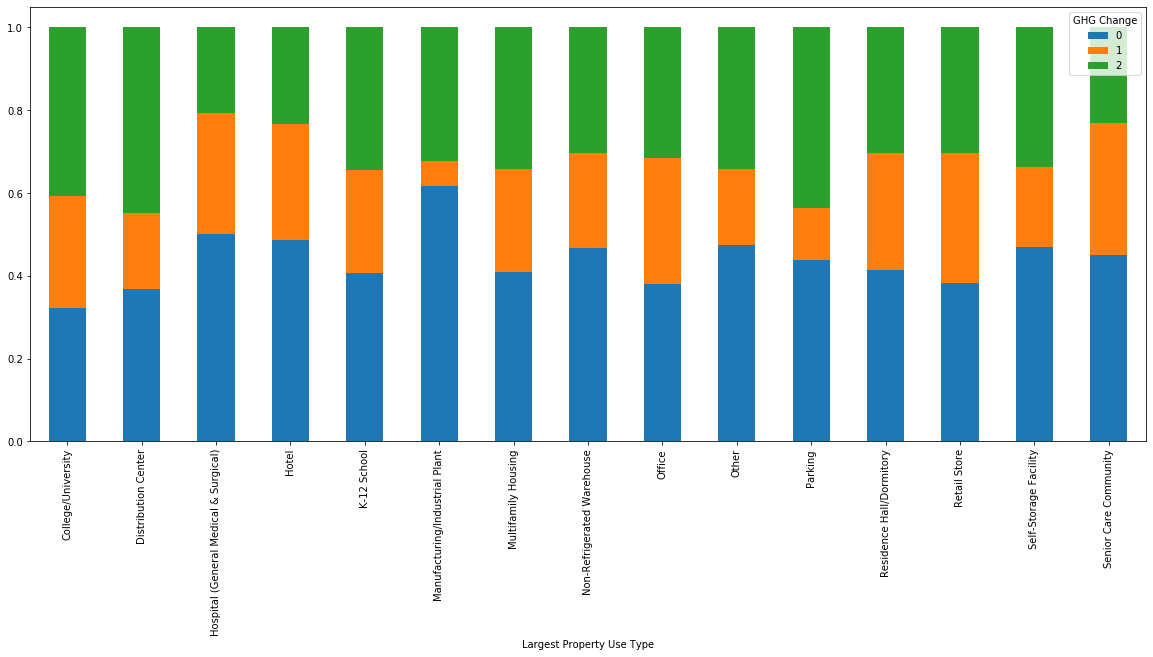

In [0]:
plt.figure(figsize=(20, 8))
props = merge.groupby("Largest Property Use Type")['GHG Change'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked='True', figsize=(20, 8))

#### Year Built

In [0]:
## convert year built to int
X['Year Built'] = X['Year Built'].str.replace(",",'').astype(int)

In [0]:
X['Year Built'].describe()

count    10868.000000
mean      1948.587229
std         29.606129
min       1393.000000
25%       1927.000000
50%       1948.000000
75%       1964.000000
max       2019.000000
Name: Year Built, dtype: float64

#### ENERGY STAR Score

In [0]:
X.loc[~X['ENERGY STAR Score'].str.contains("Not"), 'ENERGY STAR Score'].astype(int).mean() 

54.43524626209323

In [0]:
X.loc[X['ENERGY STAR Score'].str.contains("Not"), 'ENERGY STAR Score'] = "54"

In [0]:
X['ENERGY STAR Score'] = X['ENERGY STAR Score'].astype(int)

#### bldgclass

### to dummy variables

In [0]:
def transfer_dummy(df, col):
    one_hot = pd.get_dummies(df[col], prefix=col)
    df = df.drop(col, axis=1)
    df = df.join(one_hot)
    return df

In [0]:
X = transfer_dummy(X, 'Largest Property Use Type')
X = transfer_dummy(X, 'bldgclass')
X = transfer_dummy(X, 'landuse')

In [0]:
X

,Year Built,ENERGY STAR Score,Self-Reported Gross Floor Area (ft²),Occupancy,bldgarea,numfloors,comarea,resarea,officearea,retailarea,garagearea,strgearea,factryarea,assessland,assesstot,builtfar,Largest Property Use Type_Adult Education,Largest Property Use Type_Ambulatory Surgical Center,Largest Property Use Type_Automobile Dealership,Largest Property Use Type_College/University,Largest Property Use Type_Convenience Store without Gas Station,Largest Property Use Type_Data Center,Largest Property Use Type_Distribution Center,Largest Property Use Type_Enclosed Mall,Largest Property Use Type_Financial Office,Largest Property Use Type_Fitness Center/Health Club/Gym,Largest Property Use Type_Food Service,Largest Property Use Type_Hospital (General Medical & Surgical),Largest Property Use Type_Hotel,Largest Property Use Type_K-12 School,Largest Property Use Type_Laboratory,Largest Property Use Type_Library,Largest Property Use Type_Manufacturing/Industrial Plant,Largest Property Use Type_Medical Office,Largest Property Use Type_Movie Theater,Largest Property Use Type_Multifamily Housing,Largest Property Use Type_Museum,Largest Property Use Type_Non-Refrigerated Warehouse,Largest Property Use Type_Office,Largest Property Use Type_Other,Largest Property Use Type_Other - Education,Largest Property Use Type_Other - Entertainment/Public Assembly,Largest Property Use Type_Other - Lodging/Residential,Largest Property Use Type_Other - Mall,Largest Property Use Type_Other - Recreation,Largest Property Use Type_Other - Services,Largest Property Use Type_Other - Specialty Hospital,Largest Property Use Type_Other - Technology/Science,Largest Property Use Type_Outpatient Rehabilitation/Physical Therapy,Largest Property Use Type_Parking,Largest Property Use Type_Performing Arts,Largest Property Use Type_Refrigerated Warehouse,"Largest Property Use Type_Repair Services (Vehicle, Shoe, Locksmith, etc.)",Largest Property Use Type_Residence Hall/Dormitory,Largest Property Use Type_Residential Care Facility,Largest Property Use Type_Restaurant,Largest Property Use Type_Retail Store,Largest Property Use Type_Self-Storage Facility,Largest Property Use Type_Senior Care Community,Largest Property Use Type_Social/Meeting Hall,Largest Property Use Type_Strip Mall,Largest Property Use Type_Supermarket/Grocery Store,Largest Property Use Type_Urgent Care/Clinic/Other Outpatient,Largest Property Use Type_Wholesale Club/Supercenter,Largest Property Use Type_Worship Facility,bldgclass_C1,bldgclass_C4,bldgclass_C6,bldgclass_C7,bldgclass_C9,bldgclass_D0,bldgclass_D1,bldgclass_D2,bldgclass_D3,bldgclass_D4,bldgclass_D5,bldgclass_D6,bldgclass_D7,bldgclass_D8,bldgclass_D9,bldgclass_E1,bldgclass_E2,bldgclass_E7,bldgclass_E9,bldgclass_F1,bldgclass_F2,bldgclass_F4,bldgclass_F5,bldgclass_F9,bldgclass_G1,bldgclass_G2,bldgclass_G6,bldgclass_G7,bldgclass_G8,bldgclass_G9,bldgclass_H1,bldgclass_H2,bldgclass_H3,bldgclass_H5,bldgclass_H6,bldgclass_H8,bldgclass_H9,bldgclass_HB,bldgclass_HH,bldgclass_HR,bldgclass_HS,bldgclass_I1,bldgclass_I2,bldgclass_I3,bldgclass_I4,bldgclass_I5,bldgclass_I6,bldgclass_I7,bldgclass_I9,bldgclass_J5,bldgclass_J6,bldgclass_J8,bldgclass_J9,bldgclass_K1,bldgclass_K2,bldgclass_K3,bldgclass_K4,bldgclass_K6,bldgclass_K8,bldgclass_K9,bldgclass_M1,bldgclass_M4,bldgclass_M9,bldgclass_N2,bldgclass_N9,bldgclass_O1,bldgclass_O2,bldgclass_O3,bldgclass_O4,bldgclass_O5,bldgclass_O6,bldgclass_O7,bldgclass_O8,bldgclass_O9,bldgclass_P1,bldgclass_P2,bldgclass_P3,bldgclass_P5,bldgclass_P7,bldgclass_P9,bldgclass_Q1,bldgclass_R1,bldgclass_R2,bldgclass_R3,bldgclass_R4,bldgclass_R9,bldgclass_RA,bldgclass_RB,bldgclass_RC,bldgclass_RD,bldgclass_RH,bldgclass_RI,bldgclass_RK,bldgclass_RM,bldgclass_RR,bldgclass_RS,bldgclass_RW,bldgclass_RX,bldgclass_RZ,bldgclass_U0,bldgclass_U2,bldgclass_U5,bldgclass_U6,bldgclass_V1,bldgclass_W1,bldgclass_W2,bldgclass_W3,bldgclass_W4,bldgclass_W5,bldgclass_W6,bldgclass_W7,bldgclass_W8,bldgclass_W9,bldgclass_Y3,bldgclass_Y8,landuse_2.0,landuse_

In [0]:
X.dtypes

Year Built                                int64
ENERGY STAR Score                         int64
Self-Reported Gross Floor Area (ft²)    float64
Occupancy                               float64
bldgarea                                float64
                                         ...   
landuse_7.0                               uint8
landuse_8.0                               uint8
landuse_9.0                               uint8
landuse_10.0                              uint8
landuse_11.0                              uint8
Length: 190, dtype: object

## run models

In [0]:
y = Y

In [0]:
y

,GHG Change
0,
1,2
2,2
3,2
4,1
7,1
...,...
13701,2
13705,0
13707,0


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [0]:
x_train.shape

(8694, 190)

In [0]:
x_test.shape

(2174, 190)

## Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB
from mixed_naive_bayes import MixedNB

In [0]:
categ_data = [*range(16,190)]

In [0]:
MNB = MixedNB(categorical_features=categ_data )

In [0]:
MNB.fit(x_train,y_train['GHG Change'])

[2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


MixedNB(alpha=0.5, var_smoothing=1e-09)

In [0]:
print ("Accuracy: ", MNB.score(x_train,y_train['GHG Change']))

Accuracy:  0.4140786749482402


## logistic regression

In [0]:
# logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix # for confusion matrix
import sklearn.metrics as metrics # for ROC curve

In [0]:
model = LogisticRegression(multi_class='multinomial',solver='newton-cg').fit(x_train, y_train)

In [0]:
print ("Accuracy:",round(model.score(x_train, y_train),3))

Accuracy: 0.492


In [0]:
parameters = model.coef_
odds_ratio = np.exp(parameters)

In [0]:
para_results = pd.DataFrame()
para_results['feature'] = x_train.columns.tolist()
para_results['odds_ratio'] = odds_ratio[0]
para_results.sort_values(by='odds_ratio',ascending=False).head(20)

,feature,odds_ratio
88,bldgclass_F9,3.254263
152,bldgclass_RB,2.224252
103,bldgclass_HH,2.090868
119,bldgclass_K2,2.023033
140,bldgclass_P2,1.988967
157,bldgclass_RK,1.928718
32,Largest Property Use Type_Manufacturing/Indust...,1.920138
2,Self-Reported Gross Floor Area (ft²),1.818682
6,comarea,1.740795
116,bldgclass_J8,1.718173


In [0]:
# First, predicted y based on the train dataset is computed
y_prob = model.predict_proba(x_train)
y_pred_train = model.predict(x_train)
print (y_prob[:10])
print (y_pred_train.tolist()[:10])
print (y_train['GHG Change'].tolist()[:10])

# Confusion matrix
# [[TN, FP]
#  [FN, TP]]
confusion = confusion_matrix(y_train,y_pred_train)
print (confusion)

[[0.37900909 0.15097686 0.47001405]
 [0.51187724 0.18567469 0.30244807]
 [0.38551205 0.06024721 0.55424074]
 [0.37718155 0.21409825 0.4087202 ]
 [0.20398562 0.09901557 0.69699881]
 [0.59167531 0.05720539 0.3511193 ]
 [0.34040143 0.19472453 0.46487403]
 [0.44842163 0.17791962 0.37365875]
 [0.37968574 0.17672344 0.44359081]
 [0.25695565 0.26507163 0.47797271]]
[2, 0, 2, 2, 2, 0, 2, 0, 2, 2]
[2, 0, 2, 0, 2, 0, 1, 2, 0, 0]
[[2045    5 1536]
 [ 734   17  789]
 [1337    6 2225]]


In [0]:
TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]
TP = confusion[1][1]

Accuracy = (TN + TP) / (TN + FP + FN + TP)
Recall = (TP) / (TP + FN)
Precision = (TP) / (TP+FP)
Specificity = (TN) / (TN+FP)

print ("Accuracy:",Accuracy)
print ("Recall:",Recall)
print ("Precision:",Precision)
print ("Specificity:",Specificity)

Accuracy: 0.7361656551231703
Recall: 0.022636484687083888
Precision: 0.7727272727272727
Specificity: 0.9975609756097561


In [0]:
y_pred_test = model.predict(x_test)

# Confusion matrix
# [[TN, FP]
#  [FN, TP]]
confusion = confusion_matrix(y_test,y_pred_test)

print (confusion)

TN = confusion[0][0]
FP = confusion[0][1]
FN = confusion[1][0]
TP = confusion[1][1]

Accuracy = (TN + TP) / (TN + FP + FN + TP)
Recall = (TP) / (TP + FN)
Precision = (TP) / (TP+FP)
Specificity = (TN) / (TN+FP)

print ("Accuracy:",round(Accuracy,3))
print ("Recall:",round(Recall,3))
print ("Precision:",round(Precision,3))
print ("Specificity:",round(Specificity,3))

[[481   0 381]
 [193   5 202]
 [354   0 558]]
Accuracy: 0.716
Recall: 0.025
Precision: 1.0
Specificity: 1.0


## decision tree

In [0]:
from sklearn.tree import DecisionTreeClassifier

In [0]:
x_ = []
train_ = []
test_ = []
for i in range(1, x_train.shape[1]):
    clf = DecisionTreeClassifier(max_depth=i)
    clf.fit(x_train, y_train)
    train_.append(clf.score(x_train, y_train))
    test_.append(clf.score(x_test, y_test))
    x_.append(i)

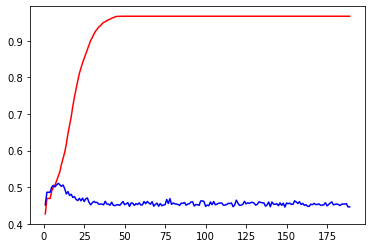

In [0]:
plt.plot(x_, train_, 'r')
plt.plot(x_, test_, 'b')
plt.show()

In [0]:
test_.index(max(test_))

8

In [0]:
# Build a model
clf = DecisionTreeClassifier(max_depth=9)

# Fit to your train data (training process)
clf.fit(x_train, y_train)

# Train/test score
print (clf.score(x_train, y_train))
print (clf.score(x_test, y_test))

0.5299056820795951
0.5114995400183993


[Text(415.18016826923076, 516.4200000000001, 'X[2] <= 0.001\ngini = 0.632\nsamples = 8694\nvalue = [3519, 1581, 3594]'),
 Text(296.57163461538465, 462.06000000000006, 'X[15] <= 0.072\ngini = 0.02\nsamples = 197\nvalue = [2, 0, 195]'),
 Text(290.1331730769231, 407.70000000000005, 'X[0] <= 1894.0\ngini = 0.01\nsamples = 196\nvalue = [1, 0, 195]'),
 Text(283.69471153846155, 353.34000000000003, 'gini = 0.375\nsamples = 4\nvalue = [1, 0, 3]'),
 Text(296.57163461538465, 353.34000000000003, 'gini = 0.0\nsamples = 192\nvalue = [0, 0, 192]'),
 Text(303.0100961538462, 407.70000000000005, 'gini = 0.0\nsamples = 1\nvalue = [1, 0, 0]'),
 Text(533.7887019230769, 462.06000000000006, 'X[1] <= 85.5\ngini = 0.634\nsamples = 8497\nvalue = [3517, 1581, 3399]'),
 Text(315.8870192307692, 407.70000000000005, 'X[2] <= 0.001\ngini = 0.634\nsamples = 7255\nvalue = [3177, 1385, 2693]'),
 Text(309.4485576923077, 353.34000000000003, 'gini = 0.168\nsamples = 108\nvalue = [98, 0, 10]'),
 Text(322.3254807692308, 353.

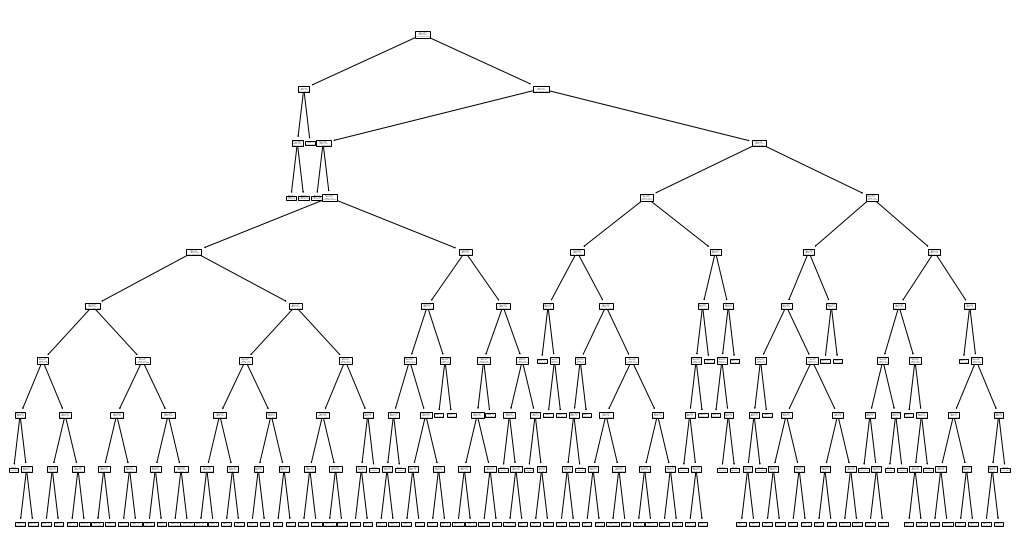

In [0]:
from sklearn import tree
plt.figure(figsize=(18,10))
tree.plot_tree(clf.fit(x_train, y_train)) 

In [0]:
print ("Feature importances: ")
print (clf.feature_importances_)
print (x_train.columns)

Feature importances: 
[0.08935906 0.17757022 0.32642263 0.00410405 0.04392032 0.04235608
 0.01725226 0.03064112 0.01370585 0.02423095 0.01529978 0.00275231
 0.         0.02954206 0.04880526 0.09387554 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00535635
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.00730737
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.0018466
 0.         0.         0.         0.         0.         0.00306686
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00229604 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0

In [0]:
dtc_imp.columns

Index(['name', 'importance'], dtype='object')

In [0]:
dtc_imp = pd.DataFrame(list(zip(x_train.columns, clf.feature_importances_)), columns=['name', 'importance']).sort_values(by='importance', ascending=False)[:16].reset_index(drop=True)

In [0]:
dtc_imp

,name,importance
0,Self-Reported Gross Floor Area (ft²),0.326423
1,ENERGY STAR Score,0.177570
2,builtfar,0.093876
3,Year Built,0.089359
4,assesstot,0.048805
5,bldgarea,0.043920
6,numfloors,0.042356
7,resarea,0.030641
8,assessland,0.029542
9,retailarea,0.024231


Text(0, 0.5, 'Feature')

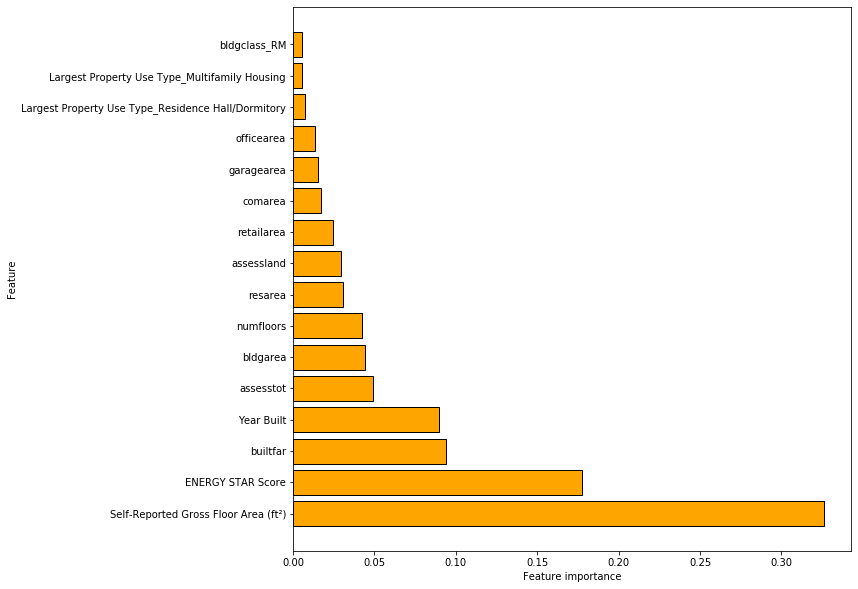

In [0]:
n_features = dtc_imp.shape[0]
plt.figure(figsize=(10,10))
plt.barh(range(n_features), dtc_imp['importance'], align='center', color='orange', edgecolor='k')
plt.yticks(np.arange(n_features), dtc_imp['name'])
plt.xlabel("Feature importance")
plt.ylabel("Feature")

## random forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

In [0]:
x_ = []
train_ = []
test_ = []
for i in range(1, 200,10):
    clf = RandomForestClassifier(n_estimators=i)
    clf.fit(x_train, y_train)
    train_.append(clf.score(x_train, y_train))
    test_.append(clf.score(x_test, y_test))
    x_.append(i)

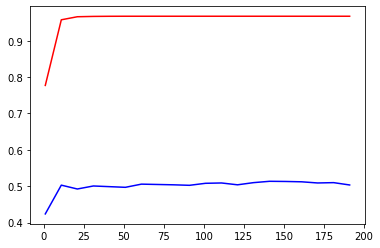

In [0]:
plt.plot(x_, train_, 'r')
plt.plot(x_, test_, 'b')
plt.show()

In [0]:
test_.index(max(test_))

14

In [0]:
# Let's build 100 trees
clf = RandomForestClassifier(n_estimators=155)
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=155,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [0]:
print (clf.score(x_train, y_train))
print (clf.score(x_test, y_test))

0.9672187715665976
0.5137994480220791


In [0]:
print ("Feature importances: ")
print (clf.feature_importances_)
print (x_train.columns)

Feature importances: 
[8.80414686e-02 1.08983782e-01 1.11545133e-01 1.19483109e-02
 9.20351063e-02 4.88316701e-02 3.47095929e-02 3.43912347e-02
 2.85684753e-02 3.18737958e-02 1.76650973e-02 1.09745496e-02
 3.33309098e-03 9.31988734e-02 9.45197070e-02 9.54404653e-02
 5.15905451e-05 2.02622094e-05 7.76853349e-05 9.13514134e-04
 7.64467224e-06 6.42167344e-05 5.38938805e-04 4.15994164e-05
 2.94947144e-04 3.65262606e-05 1.54987365e-05 4.98993563e-04
 9.46256900e-04 7.68775186e-04 1.24108509e-04 1.24094613e-04
 5.13829249e-04 4.59062878e-04 7.95311690e-05 3.35803719e-03
 1.04609026e-04 8.08646312e-04 2.82308520e-03 9.87472321e-04
 4.94367170e-04 3.45391927e-04 8.02659803e-05 9.07489246e-05
 9.77082831e-05 1.33262337e-04 2.26554185e-04 9.19448338e-05
 5.62885791e-05 3.78292448e-04 2.26639697e-04 1.24713764e-04
 0.00000000e+00 1.31731798e-03 1.42805756e-04 5.76211199e-05
 8.52709127e-04 4.35479895e-04 8.29758488e-04 1.76873534e-04
 1.58170327e-04 1.68729714e-04 1.12469391e-04 7.34826729e-05
 2

In [0]:
rfc_imp = pd.DataFrame(list(zip(x_train.columns, clf.feature_importances_)), columns=['name', 'importance']).sort_values(by='importance', ascending=False)[:16].reset_index(drop=True)

Text(0, 0.5, 'Feature')

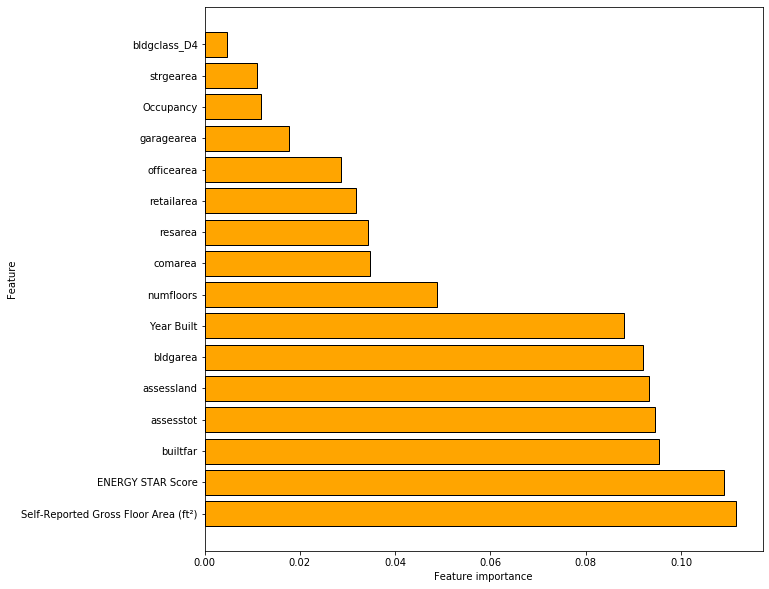

In [0]:
n_features = rfc_imp.shape[0]
plt.figure(figsize=(10,10))
plt.barh(range(n_features), rfc_imp['importance'], align='center', color='orange', edgecolor='k')
plt.yticks(np.arange(n_features), rfc_imp['name'])
plt.xlabel("Feature importance")
plt.ylabel("Feature")

## Support Vector Machines (SVMs)

In [0]:
from sklearn import svm

In [0]:
clf = svm.SVC(kernel='rbf', gamma=1) 
clf.fit(x_train, y_train)
clf.score(x_train, y_train)

0.8890039107430412